In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import ToTensor, RandomHorizontalFlip
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from tqdm import tqdm

import pandas as pd
from torchvision.ops import box_iou
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, mobilenet_backbone
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torchvision.transforms.functional as TF
import random
import matplotlib.transforms as mtransforms

from torchvision.transforms.functional import resize, pad
import torchvision.transforms.functional as F

import torchvision.transforms as T
from torchvision.transforms import ColorJitter as TorchvisionColorJitter
from ast import literal_eval

from torchvision.models.detection import fasterrcnn_resnet50_fpn



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Augmentation

In [ ]:
class RandomApply(torch.nn.Module):
    """Apply randomly a list of transformations with a given probability"""
    def __init__(self, transforms, p=0.5):
        super().__init__()
        self.transforms = transforms
        self.p = p

    def forward(self, img, target):
        if self.p < random.random():
            return img, target
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += '\n'
        for t in self.transforms:
            format_string += '    {0}\n'.format(t)
        format_string += '    p={}'.format(self.p)
        format_string += ')'
        return format_string

In [ ]:
class ResizeAndPad(object):
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, image, target):
        original_width, original_height = image.width, image.height
        target_height, target_width = self.target_size

        aspect_ratio = original_width / original_height

        if original_height > original_width:
            new_height = target_height
            new_width = int(new_height * aspect_ratio)
        else:
            new_width = target_width
            new_height = int(new_width / aspect_ratio)

        image = resize(image, (new_height, new_width))

        if "boxes" in target:
            boxes = target["boxes"]
            scale_x = new_width / original_width
            scale_y = new_height / original_height
            boxes[:, [0, 2]] *= scale_x
            boxes[:, [1, 3]] *= scale_y
            target["boxes"] = boxes

        pad_height = max(target_height - new_height, 0)
        pad_width = max(target_width - new_width, 0)

        # apply padding to the image
        image = pad(image, (0, 0, pad_width, pad_height), fill=0, padding_mode='constant')

        return image, target

In [ ]:
class ColorJitter(object):
    """A wrapper that adjusts the ColorJitter to handle both image and target."""
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.color_jitter = TorchvisionColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, image, target):
        image = self.color_jitter(image)
        return image, target

In [ ]:
class RandomHorizontalFlip(object):
    """Randomly horizontally flips the image and the bounding boxes with a given probability."""
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if torch.rand(1) < self.prob:
            image = torch.flip(image, [2])
            width = image.shape[2]
            boxes = target["boxes"]
            boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
            target["boxes"] = boxes
        return image, target

In [ ]:
class RandomScaling(object):
    """Randomly scales the image and adjusts bounding boxes accordingly."""
    def __init__(self, scale_range=(0.8, 1.2)):
        self.scale_range = scale_range

    def __call__(self, image, target):
        scale_factor = random.uniform(self.scale_range[0], self.scale_range[1])
        new_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
        image = TF.resize(image, new_size)

        # Scale bounding boxes
        if "boxes" in target:
            boxes = target["boxes"]
            # Scale bounding boxes to match new image dimensions
            boxes *= scale_factor
            target["boxes"] = boxes
        return image, target

In [ ]:
class RandomTranslation(object):
    """Randomly translates the image and adjusts bounding boxes accordingly."""
    def __init__(self, translation_range=(0.1, 0.1)):
        self.translation_range = translation_range

    def __call__(self, image, target):
        tx = random.uniform(-self.translation_range[0], self.translation_range[0]) * image.shape[1]
        ty = random.uniform(-self.translation_range[1], self.translation_range[1]) * image.shape[0]
        image = TF.affine(image, angle=0, translate=[tx, ty], scale=1, shear=0)

        # Translate bounding boxes
        if "boxes" in target:
            boxes = target["boxes"]
            # Translate bounding boxes
            boxes[:, 0::2] += tx
            boxes[:, 1::2] += ty
            target["boxes"] = boxes
        return image, target

In [ ]:
class ToTensor(object):
    """Convert PIL Images in sample to pytorch tensors."""
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [ ]:
class Compose(object):
    """Composes several transforms together for both image and target (bounding boxes)."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [ ]:
def get_transform(train):
    transforms = [
        ResizeAndPad((1024, 1024)),
        ToTensor(),
    ]
    if train:
        additional_transforms = [
            RandomHorizontalFlip(0.5),
            #RandomScaling(scale_range=(0.8, 1.2)),
            RandomTranslation(translation_range=(0.1, 0.1)),
            RandomApply([
                ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            ], p=0.4)
        ]
        transforms.extend(additional_transforms)

    return Compose(transforms)

# Loading data

In [ ]:
class BBDataset(Dataset):
    def __init__(self, dataframe, root_dir, transforms=None):
        self.image_groups = dataframe.groupby('file path')['coordinates'].agg(list).reset_index()
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_groups)

    def __getitem__(self, idx):
        img_path = self.image_groups.iloc[idx]['file path']
        image = Image.open(img_path).convert("RGB")

        coordinates = self.image_groups.iloc[idx]['coordinates']
        box_list = [literal_eval(coord) if isinstance(coord, str) else coord for coord in coordinates]
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            image, target = self.transforms(image, target)

        image_pil = to_pil_image(image)

        #if idx < 10:  # Limit this to the first few samples to avoid a flood of images
        #    show_image_with_boxes(image_pil, target["boxes"].numpy())
        return image, target

In [ ]:
def my_collate_fn(batch):
    # Extracts parts of the batch, pads, and combines them back into batch tensors
    max_height = max(item[0].shape[1] for item in batch)
    max_width = max(item[0].shape[2] for item in batch)
    padded_imgs, targets = [], []
    for img, target in batch:
        pad_height = max_height - img.shape[1]
        pad_width = max_width - img.shape[2]
        padded_img = F.pad(img, (0, pad_width, 0, pad_height), fill=0, padding_mode="constant")
        padded_imgs.append(padded_img)
        targets.append(target)
    return torch.stack(padded_imgs, dim=0), targets

In [ ]:
train_dataframe = pd.read_excel('/content/drive/MyDrive/OCR_project/All_bounding_boxes.xlsx')
train_data_path = '/content/drive/MyDrive/OCR_project/FUNSD_dataset/training_data/images/'

# Load validation data
val_dataframe = pd.read_excel('/content/drive/MyDrive/OCR_project/All_validation_bounding_boxes.xlsx')
val_data_path = '/content/drive/MyDrive/OCR_project/FUNSD_dataset/validation_data/images/'

# Define transformations
train_transforms = get_transform(train=True)
val_transforms = get_transform(train=False)

# Create training dataset
train_dataset = BBDataset(train_dataframe, train_data_path, transforms=train_transforms)

# Create validation dataset
val_dataset = BBDataset(val_dataframe, val_data_path, transforms=val_transforms)

# Create training and validation loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0, collate_fn=my_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=0, collate_fn=my_collate_fn)

In [ ]:
# helper function to check bounding boxes are correctly placed on documents
def show_image_with_boxes(image, boxes, labels=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# The model

# Training the model

In [ ]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def train_model(model, data_loader, optimizer, device, num_epochs=100):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Use tqdm to add a progress bar to the inner loop
        progress_bar = tqdm(data_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True)
        for images, targets in progress_bar:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()
            # Update the progress bar with the current loss
            progress_bar.set_postfix({'loss': running_loss / len(data_loader)})
        print(f"Epoch {epoch + 1} Average Loss: {running_loss / len(data_loader)}")
        #evaluate_model(model, val_loader, device)

model = get_model(num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_model(model, train_loader, optimizer, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 168MB/s]
Epoch 1/100: 100%|██████████| 15/15 [01:44<00:00,  6.95s/it, loss=2.68]


Epoch 1 Average Loss: 2.67948203086853


Epoch 2/100: 100%|██████████| 15/15 [00:51<00:00,  3.44s/it, loss=1.53]


Epoch 2 Average Loss: 1.5300136884053548


Epoch 3/100: 100%|██████████| 15/15 [00:54<00:00,  3.62s/it, loss=1.37]


Epoch 3 Average Loss: 1.3703603426615396


Epoch 4/100: 100%|██████████| 15/15 [00:51<00:00,  3.45s/it, loss=1.21]


Epoch 4 Average Loss: 1.2111553430557251


Epoch 5/100: 100%|██████████| 15/15 [00:51<00:00,  3.46s/it, loss=1.1]


Epoch 5 Average Loss: 1.1015623092651368


Epoch 6/100: 100%|██████████| 15/15 [00:52<00:00,  3.53s/it, loss=1.03]


Epoch 6 Average Loss: 1.0335941195487977


Epoch 7/100: 100%|██████████| 15/15 [00:55<00:00,  3.68s/it, loss=0.99]


Epoch 7 Average Loss: 0.9898031989733378


Epoch 8/100: 100%|██████████| 15/15 [00:56<00:00,  3.77s/it, loss=0.956]


Epoch 8 Average Loss: 0.956340471903483


Epoch 9/100: 100%|██████████| 15/15 [00:54<00:00,  3.61s/it, loss=0.962]


Epoch 9 Average Loss: 0.9621466040611267


Epoch 10/100: 100%|██████████| 15/15 [00:54<00:00,  3.63s/it, loss=0.919]


Epoch 10 Average Loss: 0.9193965196609497


Epoch 11/100: 100%|██████████| 15/15 [00:51<00:00,  3.46s/it, loss=0.892]


Epoch 11 Average Loss: 0.8917818427085876


Epoch 12/100: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it, loss=0.876]


Epoch 12 Average Loss: 0.8756146232287089


Epoch 13/100: 100%|██████████| 15/15 [00:52<00:00,  3.47s/it, loss=0.874]


Epoch 13 Average Loss: 0.8737790981928507


Epoch 14/100: 100%|██████████| 15/15 [00:53<00:00,  3.55s/it, loss=0.861]


Epoch 14 Average Loss: 0.8605688214302063


Epoch 15/100: 100%|██████████| 15/15 [00:54<00:00,  3.61s/it, loss=0.85]


Epoch 15 Average Loss: 0.8498281399408977


Epoch 16/100: 100%|██████████| 15/15 [00:53<00:00,  3.55s/it, loss=0.84]


Epoch 16 Average Loss: 0.8404164989789327


Epoch 17/100: 100%|██████████| 15/15 [00:54<00:00,  3.63s/it, loss=0.827]


Epoch 17 Average Loss: 0.827401606241862


Epoch 18/100: 100%|██████████| 15/15 [00:54<00:00,  3.66s/it, loss=0.819]


Epoch 18 Average Loss: 0.8190653999646504


Epoch 19/100: 100%|██████████| 15/15 [00:55<00:00,  3.72s/it, loss=0.82]


Epoch 19 Average Loss: 0.819664458433787


Epoch 20/100: 100%|██████████| 15/15 [00:54<00:00,  3.61s/it, loss=0.805]


Epoch 20 Average Loss: 0.8049784501393636


Epoch 21/100: 100%|██████████| 15/15 [00:54<00:00,  3.62s/it, loss=0.793]


Epoch 21 Average Loss: 0.7933324535687765


Epoch 22/100: 100%|██████████| 15/15 [00:54<00:00,  3.65s/it, loss=0.79]


Epoch 22 Average Loss: 0.7899686853090923


Epoch 23/100: 100%|██████████| 15/15 [00:54<00:00,  3.65s/it, loss=0.791]


Epoch 23 Average Loss: 0.7906622171401978


Epoch 24/100: 100%|██████████| 15/15 [00:58<00:00,  3.87s/it, loss=0.781]


Epoch 24 Average Loss: 0.7811958352724712


Epoch 25/100: 100%|██████████| 15/15 [00:54<00:00,  3.64s/it, loss=0.762]


Epoch 25 Average Loss: 0.7616655468940735


Epoch 26/100: 100%|██████████| 15/15 [00:52<00:00,  3.52s/it, loss=0.76]


Epoch 26 Average Loss: 0.7596692283948262


Epoch 27/100: 100%|██████████| 15/15 [00:54<00:00,  3.61s/it, loss=0.755]


Epoch 27 Average Loss: 0.7550405303637187


Epoch 28/100: 100%|██████████| 15/15 [00:52<00:00,  3.53s/it, loss=0.756]


Epoch 28 Average Loss: 0.756087863445282


Epoch 29/100: 100%|██████████| 15/15 [00:56<00:00,  3.77s/it, loss=0.753]


Epoch 29 Average Loss: 0.7527475595474243


Epoch 30/100: 100%|██████████| 15/15 [00:52<00:00,  3.48s/it, loss=0.753]


Epoch 30 Average Loss: 0.7526739160219829


Epoch 31/100: 100%|██████████| 15/15 [00:54<00:00,  3.61s/it, loss=0.728]


Epoch 31 Average Loss: 0.7282158931096395


Epoch 32/100: 100%|██████████| 15/15 [00:53<00:00,  3.56s/it, loss=0.712]


Epoch 32 Average Loss: 0.7124695658683777


Epoch 33/100: 100%|██████████| 15/15 [00:51<00:00,  3.45s/it, loss=0.71]


Epoch 33 Average Loss: 0.7098406871159871


Epoch 34/100: 100%|██████████| 15/15 [00:52<00:00,  3.49s/it, loss=0.703]


Epoch 34 Average Loss: 0.7027975638707479


Epoch 35/100: 100%|██████████| 15/15 [00:54<00:00,  3.66s/it, loss=0.69]


Epoch 35 Average Loss: 0.6897990743319193


Epoch 36/100: 100%|██████████| 15/15 [00:54<00:00,  3.63s/it, loss=0.686]


Epoch 36 Average Loss: 0.6864759683609009


Epoch 37/100: 100%|██████████| 15/15 [00:53<00:00,  3.54s/it, loss=0.685]


Epoch 37 Average Loss: 0.6847490708033244


Epoch 38/100: 100%|██████████| 15/15 [00:51<00:00,  3.45s/it, loss=0.674]


Epoch 38 Average Loss: 0.6741034388542175


Epoch 39/100: 100%|██████████| 15/15 [00:52<00:00,  3.53s/it, loss=0.671]


Epoch 39 Average Loss: 0.6714799722035726


Epoch 40/100: 100%|██████████| 15/15 [00:52<00:00,  3.50s/it, loss=0.658]


Epoch 40 Average Loss: 0.6582761287689209


Epoch 41/100: 100%|██████████| 15/15 [00:54<00:00,  3.64s/it, loss=0.658]


Epoch 41 Average Loss: 0.6584521253903707


Epoch 42/100: 100%|██████████| 15/15 [00:54<00:00,  3.64s/it, loss=0.66]


Epoch 42 Average Loss: 0.660073983669281


Epoch 43/100: 100%|██████████| 15/15 [00:54<00:00,  3.64s/it, loss=0.635]


Epoch 43 Average Loss: 0.634614900747935


Epoch 44/100: 100%|██████████| 15/15 [00:54<00:00,  3.62s/it, loss=0.642]


Epoch 44 Average Loss: 0.6422893166542053


Epoch 45/100: 100%|██████████| 15/15 [00:57<00:00,  3.83s/it, loss=0.643]


Epoch 45 Average Loss: 0.6430404583613077


Epoch 46/100:  67%|██████▋   | 10/15 [00:36<00:18,  3.70s/it, loss=0.424]


KeyboardInterrupt: 

## Saving & loading trained model

In [ ]:
# saving
torch.save(model, '/content/drive/MyDrive/OCR_project/bb_detector2.pth')

In [ ]:
# loading
model = torch.load('/content/drive/MyDrive/OCR_project/bb_detector.pth')

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Evaluation on the validation set

## IoU

In [ ]:
import torch
import torchvision
from torchvision.ops import box_iou
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    all_ious = []
    all_precisions = []
    all_recalls = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()
                gt_boxes = target['boxes'].cpu()

                iou = box_iou(gt_boxes, pred_boxes)
                max_iou, max_indices = torch.max(iou, dim=1) if iou.numel() > 0 else (torch.tensor([]), torch.tensor([]))

                # Compute IoU-based metrics
                true_positives = (max_iou >= iou_threshold).sum().item()
                false_positives = (max_iou < iou_threshold).sum().item()
                false_negatives = len(gt_boxes) - true_positives

                precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
                recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

                all_ious.extend(max_iou.tolist())
                all_precisions.append(precision)
                all_recalls.append(recall)

    # getting metrics
    mean_iou = np.mean(all_ious) if all_ious else 0
    mean_precision = np.mean(all_precisions) if all_precisions else 0
    mean_recall = np.mean(all_recalls) if all_recalls else 0
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0

    print(f"Mean IoU: {mean_iou}")
    print(f"Mean Precision: {mean_precision}")
    print(f"Mean Recall: {mean_recall}")
    print(f"F1 Score: {f1_score}")

    return mean_iou, mean_precision, mean_recall, f1_score

evaluate_model(model, val_loader, device)


Mean IoU: 0.6968192122244646
Mean Precision: 0.8571559819182135
Mean Recall: 0.8571559819182135
F1 Score: 0.8571559819182135


(0.6968192122244646,
 0.8571559819182135,
 0.8571559819182135,
 0.8571559819182135)

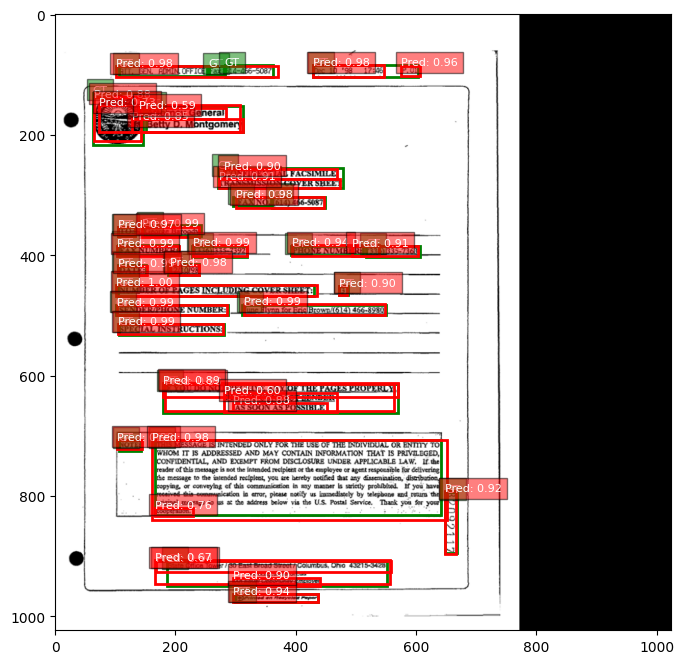

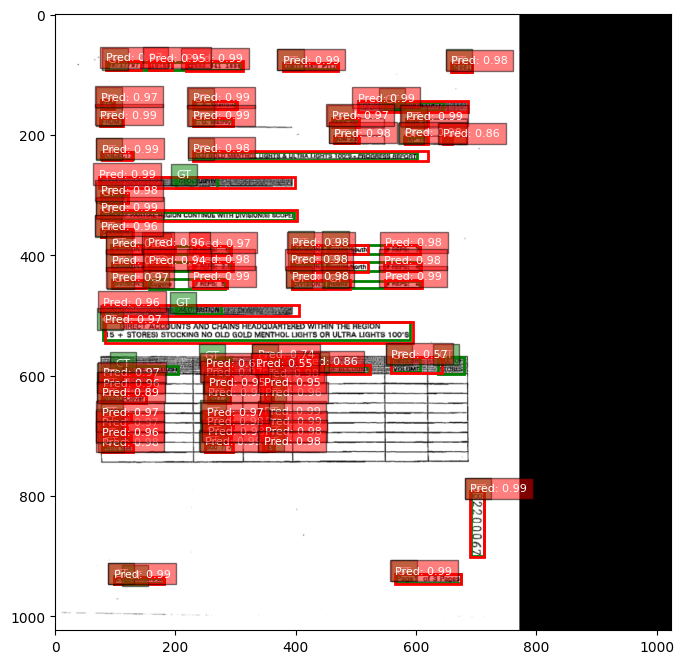

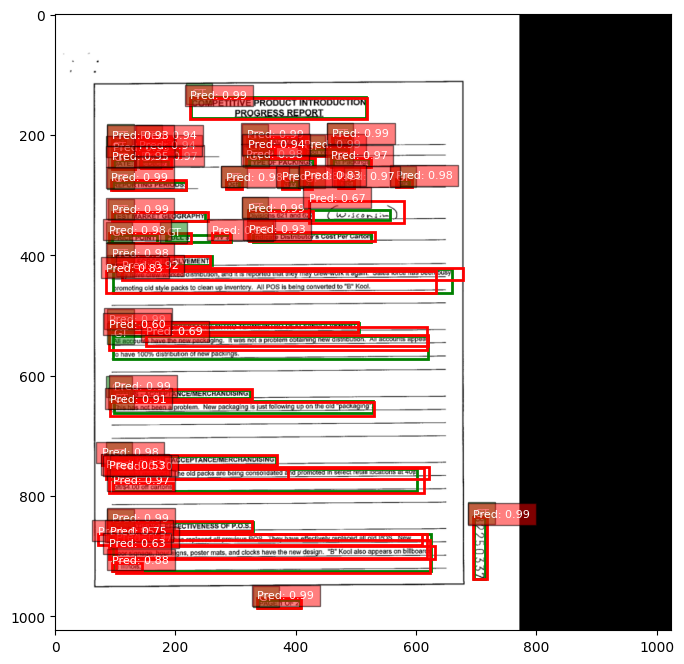

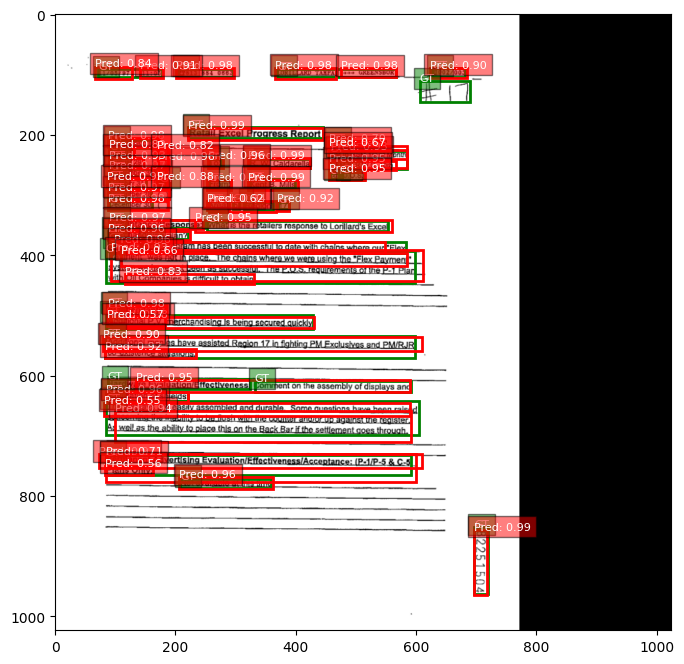

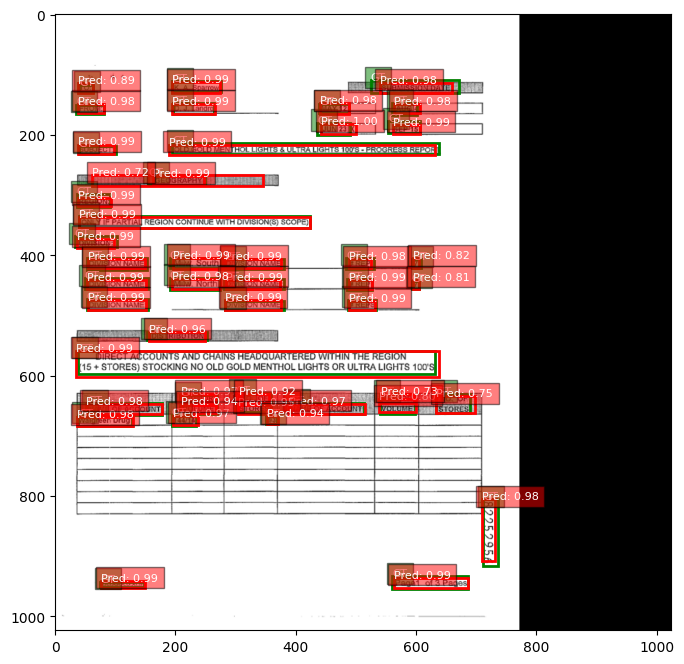

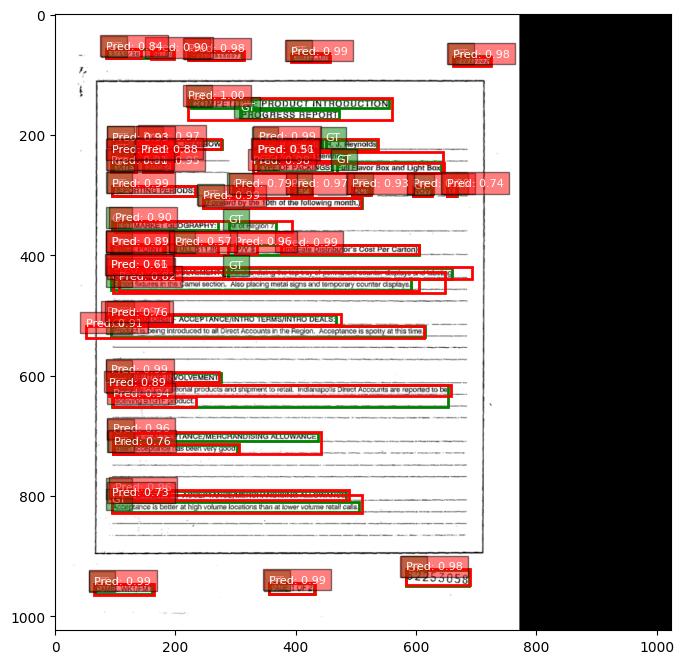

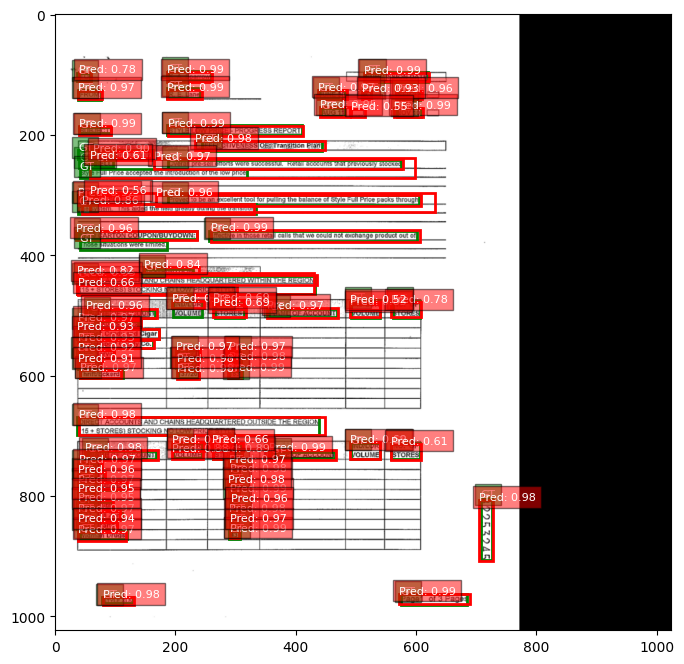

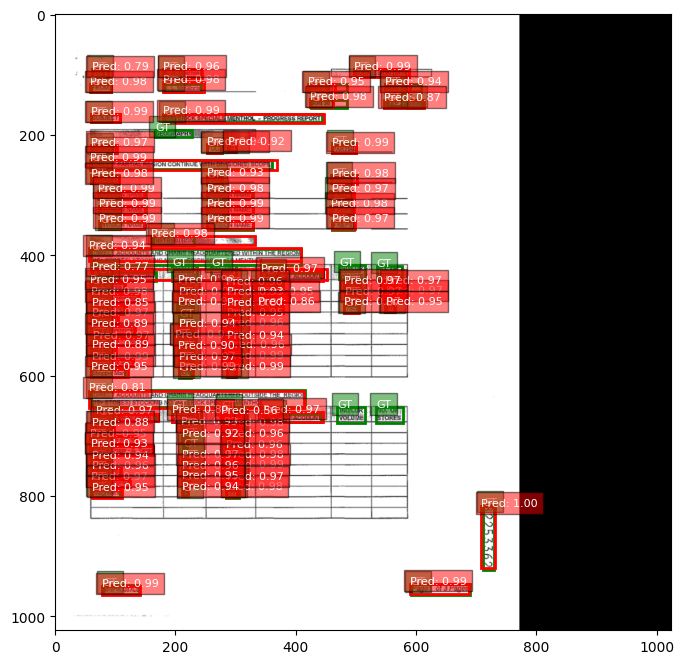

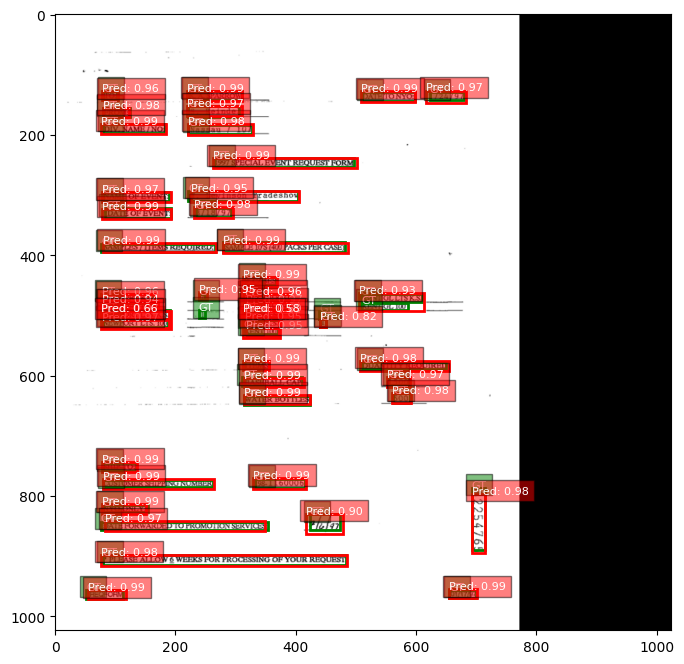

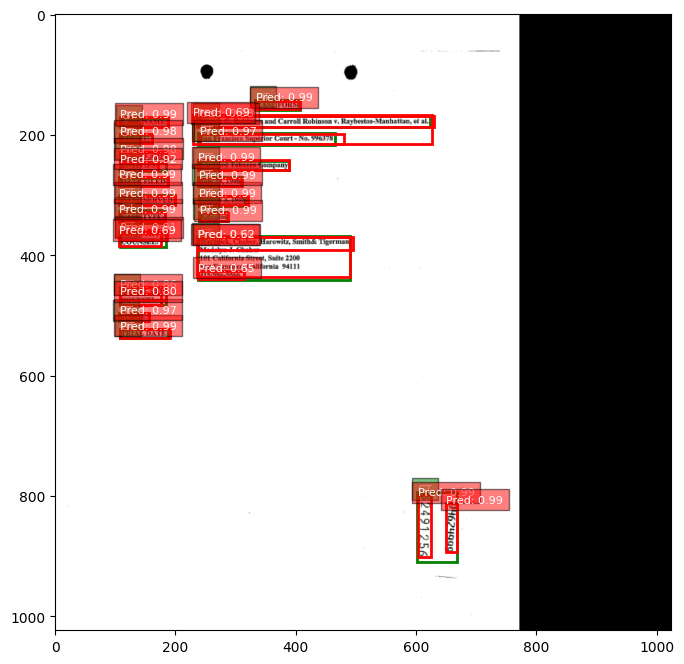

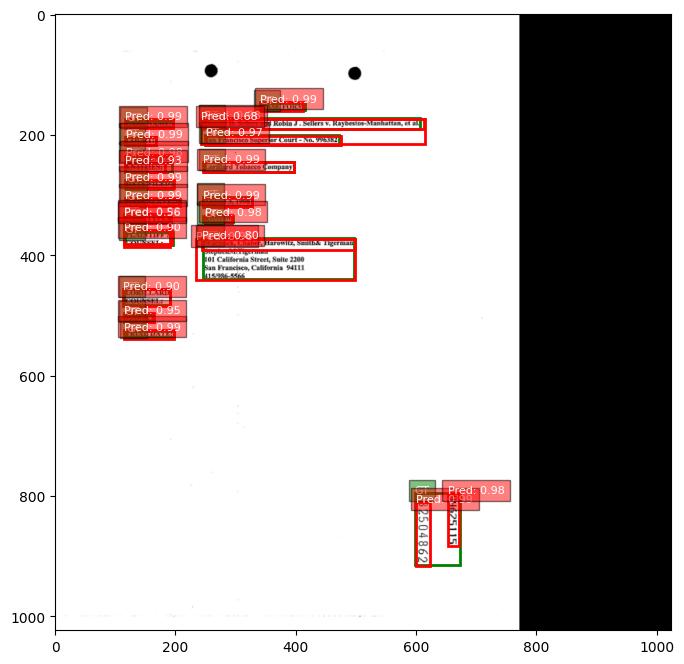

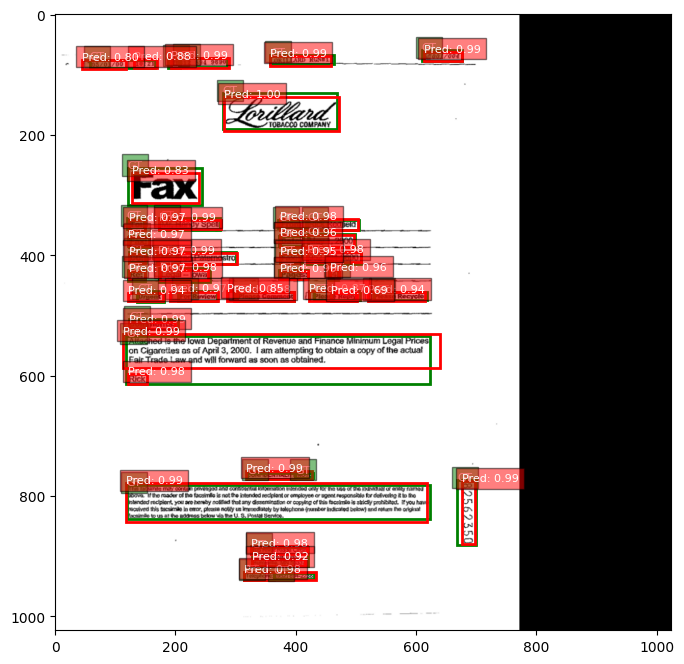

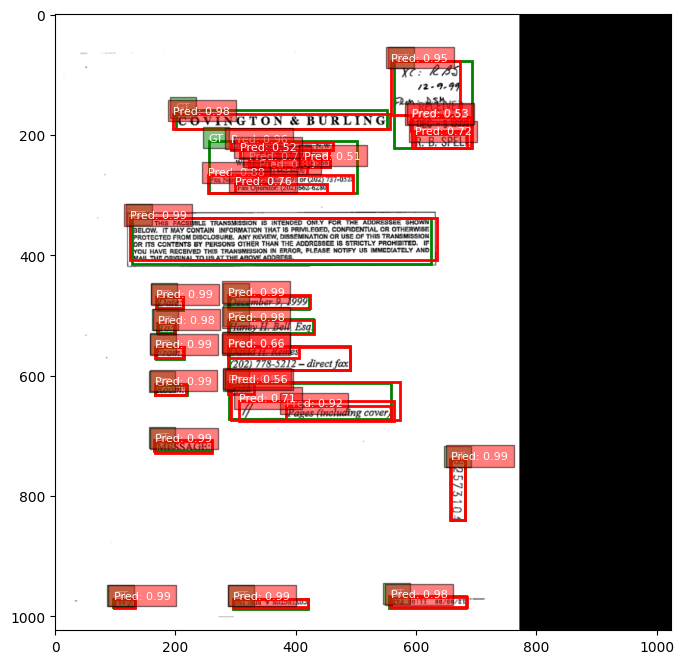

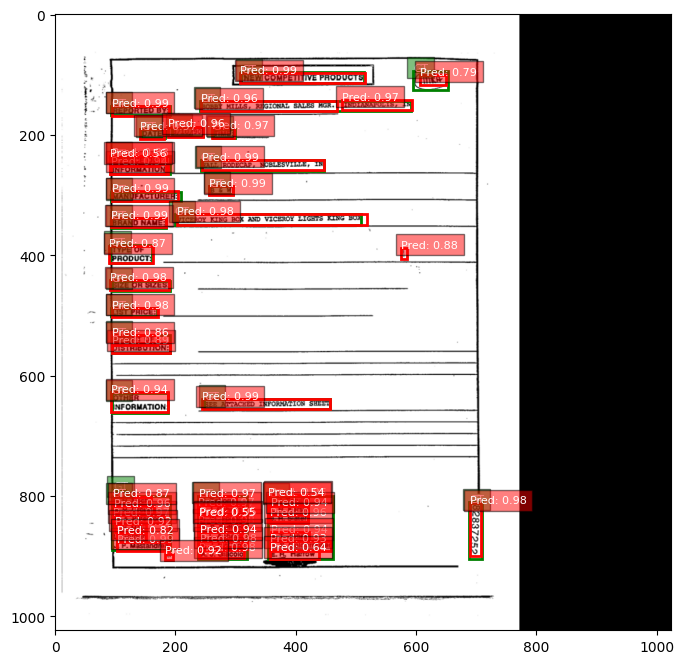

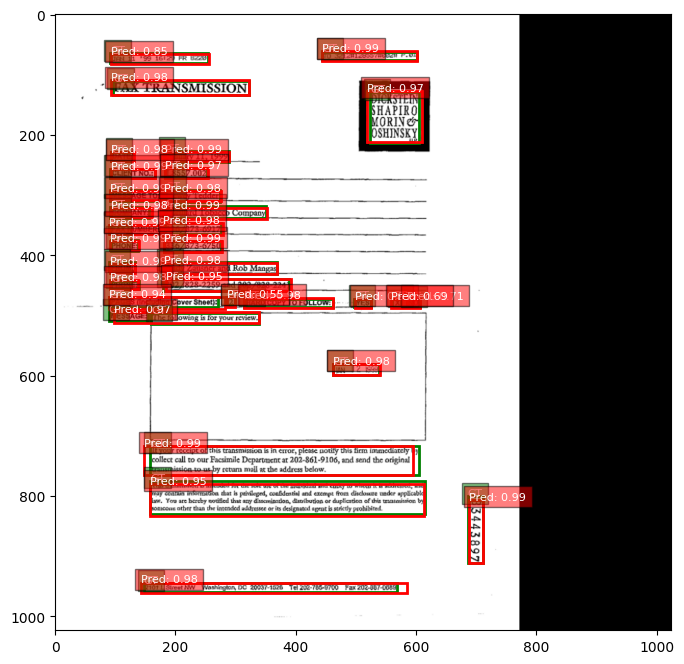

Mean IoU: 0.6968192122244646
Mean Precision: 0.8571559819182135
Mean Recall: 0.8571559819182135
F1 Score: 0.8571559819182135


(0.6968192122244646,
 0.8571559819182135,
 0.8571559819182135,
 0.8571559819182135)

In [ ]:
import torch
import torchvision
from torchvision.ops import box_iou
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def add_box(ax, box, label, color):
    """Helper function to add a box to the axes."""
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], label, bbox=dict(facecolor=color, alpha=0.5), fontsize=8, color='white')

def evaluate_model(model, data_loader, device, iou_threshold=0.5, num_images_to_show=15):
    model.eval()
    all_ious = []
    all_precisions = []
    all_recalls = []
    images_shown = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for image, output, target in zip(images, outputs, targets):
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()
                gt_boxes = target['boxes'].cpu()

                iou = box_iou(gt_boxes, pred_boxes)
                max_iou, max_indices = torch.max(iou, dim=1) if iou.numel() > 0 else (torch.tensor([]), torch.tensor([]))

                true_positives = (max_iou >= iou_threshold).sum().item()
                false_positives = (max_iou < iou_threshold).sum().item()
                false_negatives = len(gt_boxes) - true_positives

                precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
                recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

                all_ious.extend(max_iou.tolist())
                all_precisions.append(precision)
                all_recalls.append(recall)

                if images_shown < num_images_to_show:
                    fig, ax = plt.subplots(1, figsize=(12, 8))
                    img = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
                    ax.imshow(img)
                    for box in gt_boxes:
                        add_box(ax, box, "GT", 'green')
                    for box, score in zip(pred_boxes, pred_scores):
                        if score > iou_threshold:
                            add_box(ax, box, f"Pred: {score:.2f}", 'red')
                    plt.show()
                    images_shown += 1

    mean_iou = np.mean(all_ious) if all_ious else 0
    mean_precision = np.mean(all_precisions) if all_precisions else 0
    mean_recall = np.mean(all_recalls) if all_recalls else 0
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0

    print(f"Mean IoU: {mean_iou}")
    print(f"Mean Precision: {mean_precision}")
    print(f"Mean Recall: {mean_recall}")
    print(f"F1 Score: {f1_score}")

    return mean_iou, mean_precision, mean_recall, f1_score

# Example usage:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
evaluate_model(model, val_loader, device)
